In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import os

<xarray.Dataset>
Dimensions:         (time: 192853, layer: 80)
Coordinates:
  * time            (time) datetime64[ns] 2000-04-20 ... 2022-04-20T12:00:00
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
Data variables: (12/33)
    melt            (time) float64 ...
    refreeze        (time) float64 ...
    runoff          (time) float64 ...
    accum           (time) float64 ...
    snowdepth       (time) float64 ...
    cumrefreeze     (time) float64 ...
    ...              ...
    layergrainsize  (time, layer) float64 ...
    layerrefreeze   (time, layer) float64 ...
    SWnet           (time) float64 ...
    LWnet           (time) float64 ...
    NetRad          (time) float64 ...
    MB              (time) float64 ...
Attributes: (12/17)
    from_AWS:         Gulkana 1480.0: wind, temp
    from_reanalysis:  MERRA2: tp, rh, sp, SWin, LWin, bcwet, bcdry, dustwet, ...
    run_start:        2000-04-20 00:00
    run_end:          2022-04-20 12:00
    elevation:        1843.0 m a.s.l.
    model_run_date:   2024-11-01 11:42:08.411420
    ...               ...
    glacier:          Gulkana
    params_fn:        ../Output/params/10_30.csv
    site:             D
    kp:               3.0
    kw:               0.5
    AWS:              ../climate_data/AWS/Preprocessed/gulkana_22yrs.csv

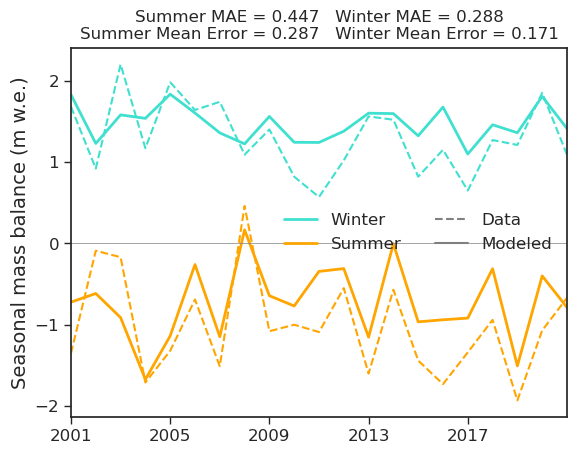

In [9]:
site = 'D'
ds,s,e = getds(f'../Output/calibration/Gulkana_2024_11_01_{site}_0.nc')
seasonal_mass_balance(site,ds,plot=True)
ds

In [22]:
site_profiles = {'A':[],'AB':[],'B':[],'D':[]}
for site in site_profiles:
    fp = '../MB_data/Point/gulkana/pitcore/'
    files = os.listdir(fp)
    profiles = {'sbd':{},'density':{}}
    for f in files:
        s = f.split('_')[-1].split('.')[0]
        if s == site and 'Pit' in f:
            if '_04' in f:
                year = int(f[8:12])
                df = pd.read_csv(fp + f)
                if len(df['sample_bottom_depth']) > 2:
                    profiles['sbd'][year] = df['sample_bottom_depth'].to_numpy()
                    density = df['sample_weight'] / df['volume'] * 1000
                    profiles['density'][year] = density.to_numpy()
    site_profiles[site] = profiles

In [ ]:
albedo = pd.read_csv('../Data/FieldSpec/gulkana_cleanice_avg.csv')
other = pd.read_csv('biosnicar-py/Data/OP_data/480band/r_sfc/gulkana_dirty_ice.csv',names=['reflectance'])
albedo.index = np.arange(350, 2501) / 1000
snicar_bands = np.round(np.arange(0.2,5,0.01),2) 
other.index = snicar_bands
bounds = [0.6,albedo.loc[.350,'reflectance']]
for i in np.arange(0.2,0.35,0.01):
    value = np.interp(i,[0.2,0.35],bounds)
    albedo.loc[np.round(i,3),'reflectance'] = value
for i in np.arange(1.5,5,0.01):
    value = other.loc[np.round(i,3),'reflectance']
    albedo.loc[np.round(i,3),'reflectance'] = value
albedo = albedo.sort_index().loc[snicar_bands]
plt.plot(albedo.index,albedo['reflectance'])
albedo.to_csv('biosnicar-py/Data/OP_data/480band/r_sfc/gulkana_clean_ice.csv')

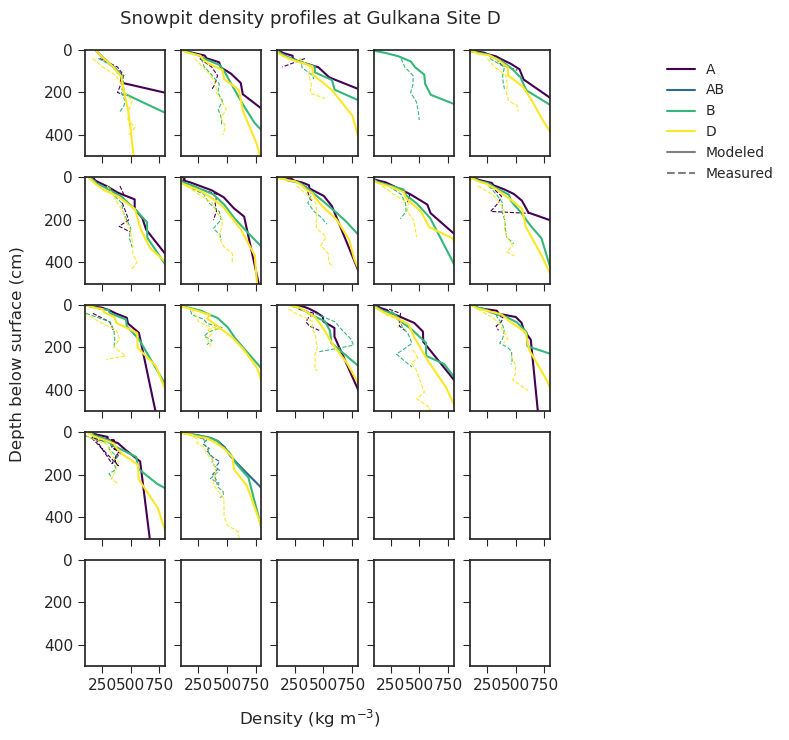

In [ ]:
years = np.arange(2000,2025)
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True)
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=len(site_profiles)-1)
cmap = mpl.colormaps.get_cmap('viridis')
for ss,site in enumerate(site_profiles):
    ds,s,e =  getds(f'../Output/EB/Gulkana_2024_10_29_{site}_1.nc')
    profiles = site_profiles[site]
    for ax,year in zip(axes,years):
        if year in profiles['sbd']:
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-04-20'))
            lheight = dsyear.layerheight.values*100
            ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
            ldensity = dsyear['layerdensity'].values
            interp_density = np.interp(profiles['sbd'][year],ldepth,ldensity)
            diff = profiles['density'][year] - interp_density
            ax.plot(diff,profiles['sbd'][year],color=cmap(norm(ss)))
            # ax.plot(ldensity,ldepth,color=cmap(norm(ss)))
            # ax.plot(profiles['density'][year],profiles['sbd'][year],color=cmap(norm(ss)),linestyle='--',linewidth=0.8)
    axes[4].plot(np.nan,np.nan,label=site,color=cmap(norm(ss)))
axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
axes[4].plot(np.nan,np.nan,label='Measured',linestyle='--',color='grey')
for ax in axes:
    ax.invert_yaxis()
    ax.set_ylim(500,0)
    ax.tick_params(length=5,labelsize=11)
    ax.set_xlim(-300,300)
fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.03)
fig.supylabel('Depth below surface (cm)',fontsize=12,x=0)
# axes[0].legend(bbox_to_anchor=(5.6,0.65))
axes[4].legend(bbox_to_anchor=(2.3,1))
fig.suptitle(f'Snowpit density profiles at Gulkana Site {site}',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../MB_data/Point/gulkana_pits_modeled.png',dpi=200,bbox_inches='tight')

Internal acc: 0.000 m w.e.


(<Figure size 300x600 with 1 Axes>,
 <Axes: title={'center': 'MAE = 0.237 m\nModeled MB: -1.619 m w.e.\nMeasured MB: -1.790 m w.e.'}, ylabel='Surface height change (m)'>)

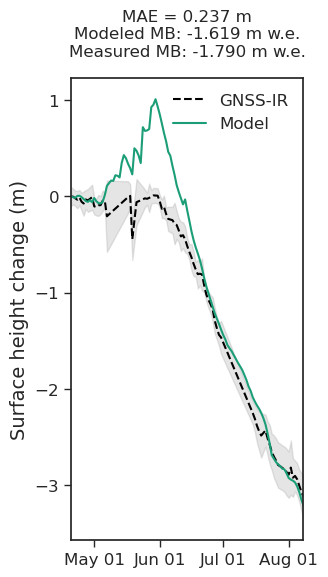

In [ ]:
bds,startdate,enddate = getds(f'../Output/EB/Gulkana_10_29_2024B_33.nc')
# fig, ax = visualize_layers(bds,pd.date_range(startdate,enddate),['layertemp'])
# ax.axvline(pd.to_datetime('2024-05-27'),color='black')
# fig.suptitle('Using lowered daytime temperatures')
# plt.savefig('../Output/EB/better_ripening.png',dpi=180,bbox_inches='tight')

Compare albedo

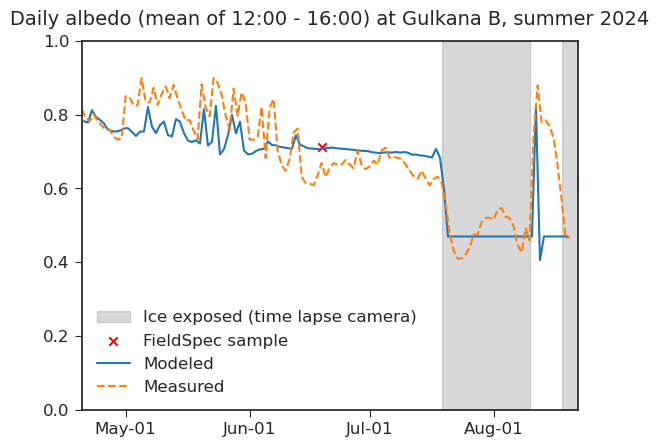

In [63]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/CLAWS_2024_allvars.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
dates = pd.date_range('2024-04-20','2024-08-22',freq='d')
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-07-19')],[pd.to_datetime('2024-08-10')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(labelsize=12)
ax.set_xticks(pd.date_range(dates[0],dates[-1],freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14,y=1.02)
plt.tick_params(size=5)
dsp = bds.sel(time=pd.date_range('2024-04-20 14:00','2024-08-19 14:00'))
ax.plot(dsp.time,dsp['albedo'],label='Modeled')
ax.plot(dates,daily_albedo,label='Measured',linestyle='--')
ax.legend(fontsize=12)
# plt.show()
plt.savefig('/home/claire/research/Output/EB/albedo_modeled_10_31.png',dpi=150,bbox_inches='tight')


kp = 1, threshold= [1.2,3.2] not bad = id 3
kp = 3, threshold = [1.2,3.2] terrible
kp = 3, threshold = [0,2] not bad = id 4

Site B internal acc: 0.00865 m w.e.
Site D internal acc: 0.26425 m w.e.
Site T internal acc: 0.11841 m w.e.


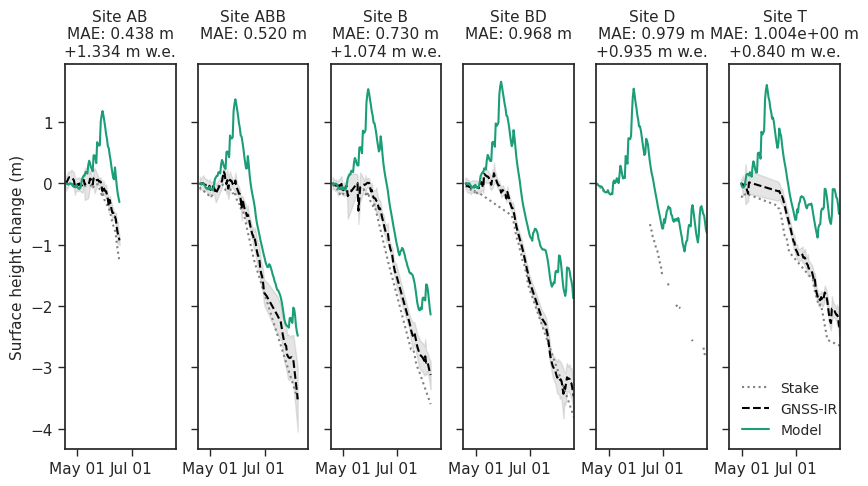

In [23]:
id = 0 # Best on 10/31: 7 (kp=2)
fig,axes = plt.subplots(1,6,figsize=(10,5),sharey=True)
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    ds,startdate,enddate = getds(f'../Output/EB/Gulkana_11_01_2024{site}_{id}.nc')
    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i] = cumulative_mass_balance(site,ds,plot=True,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}\n'+axes[i].get_title(),fontsize=11)
    axes[i].set_ylabel('')
    axes[i].get_legend().remove()
    axes[i].set_xlim(startdate,enddate)
    axes[i].set_xticks(pd.date_range(startdate,enddate,freq='2MS'))
    axes[i].tick_params(labelsize=11)
axes[-1].legend(facecolor='white',fontsize=10)
axes[0].set_ylabel('Surface height change (m)',fontsize=11)
# plt.savefig(f'/home/claire/research/Output/EB/gulkana_dh_10_31.png',dpi=180,bbox_inches='tight')
plt.show()

In [24]:
ds,startdate,enddate = getds(f'../Output/EB/run1/Gulkana_11_01_2024AB_0.nc')
# visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layerdensity'])
ds

<xarray.Dataset>
Dimensions:         (time: 2983, layer: 80)
Coordinates:
  * time            (time) datetime64[ns] 2024-04-17T18:00:00 ... 2024-08-20
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
Data variables: (12/33)
    melt            (time) float64 ...
    refreeze        (time) float64 ...
    runoff          (time) float64 ...
    accum           (time) float64 ...
    snowdepth       (time) float64 ...
    cumrefreeze     (time) float64 ...
    ...              ...
    layergrainsize  (time, layer) float64 ...
    layerrefreeze   (time, layer) float64 ...
    SWnet           (time) float64 ...
    LWnet           (time) float64 ...
    NetRad          (time) float64 ...
    MB              (time) float64 ...
Attributes: (12/17)
    from_AWS:         Gulkana 1682.0: SWin, LWin, rh, wind, sp, temp
    from_reanalysis:  MERRA2: tp, bcwet, bcdry, dustwet, dustdry
    run_start:        2024-04-17 18:00
    run_end:          2024-08-20 00:00
    elevation:        1542.0 m a.s.l.
    model_run_date:   2024-11-01 13:35:29.962057
    ...               ...
    glacier:          Gulkana
    params_fn:        ../Output/params/10_30.csv
    site:             AB
    kp:               3.0
    kw:               1.0
    AWS:              ../climate_data/AWS/Preprocessed/gulkana2024_-T_noalbed...

In [109]:
import sys
sys.path.append(os.getcwd()+'/biosnicar-py/')
from biosnicar import get_albedo
_,weights = get_albedo.get('adding-doubling',plot=False,validate=False)
# a = pd.read_csv('biosnicar-py/Data/OP_data/480band/r_sfc/gulkana_dirty_ice.csv',names=['reflect'])
# np.sum(a['reflect']*weights)/np.sum(weights)


Running biosnicar with the adding-doubling solver


** OUTPUT DATA **
Broadband albedo:  0.6734

BAND RATIO INDEX VALUES
2DBA Index:  0.9754617798552916
3DBA index:  0.01775887239571081
NDCI index:  0.007431228089770227
MCI index:  -0.008386085402010827
Impurity Index:  0.3587204236138681


ACTUAL CALIBRATION

In [ ]:
# FIND BEST RUN IN A SET
date = '10_18'
path_out = f'/home/claire/research/Output/calibration/{date}_0/'
sites= ['AB','B','D']
# fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
dsdict = {'AB':[],'B':[],'D':[]}
outdict = {'AB':[],'B':[],'D':[]}
for i in range(85):
    fn = f'calibration_{date}_run{i}_0.nc'
    try:
        ds,startdate,enddate = getds(path_out+fn)
    except:
        print(fn,'doesnt exist')
        continue
    site = ds.attrs['site']
    winter,summer = seasonal_mass_balance(site,ds)
    dsdict[site].append(ds)
    # if i % 5 == 0:
    #     print(ds.attrs[param])
    # outdict[site].append(np.mean([winter,summer]))
    outdict[site].append(summer)
    # print(ds.attrs['k_snow'],winter,summer,np.mean([winter,summer]))
best = {}
for site in sites:
    best[site] = dsdict[site][np.argmin(outdict[site])]
    print(site,np.argmin(outdict[site]))
    # simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

AB 27
B 25
D 23


In [6]:
result_df = pd.DataFrame(data=np.zeros((len(sites),3)),columns=sites,index=['kp','kw','a_ice'])
for site in sites:
    ds = best[site]
    result_df.loc['kp',site] = float(ds.attrs['kp'])
    if site == 'D':
        result_df.loc['kw',site] = 2 #float(ds.attrs['kw'])
        result_df.loc['a_ice',site] = 0.4
    else:
        result_df.loc['a_ice',site] = float(ds.attrs['a_ice'])
        result_df.loc['kw',site] = 3
# result_df.to_csv(f'/home/claire/research/Gulkana_params_{date}_HIGHWIND.csv',sep=',')
print(result_df)

         AB    B    D
kp     3.20  3.2  3.2
kw     3.00  3.0  2.0
a_ice  0.25  0.4  0.4


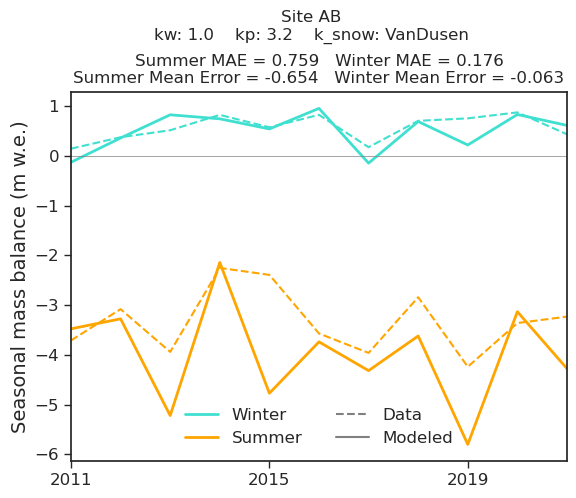

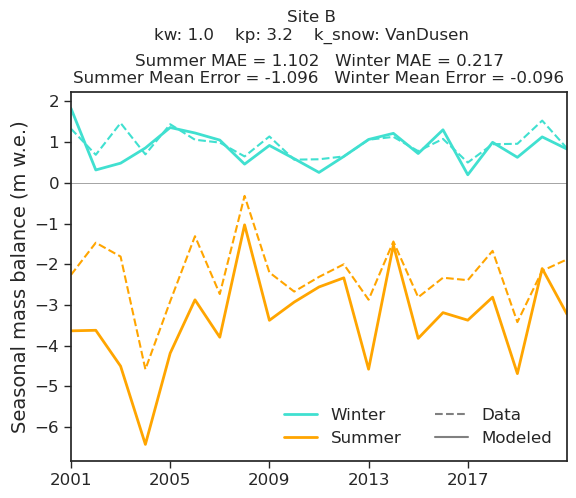

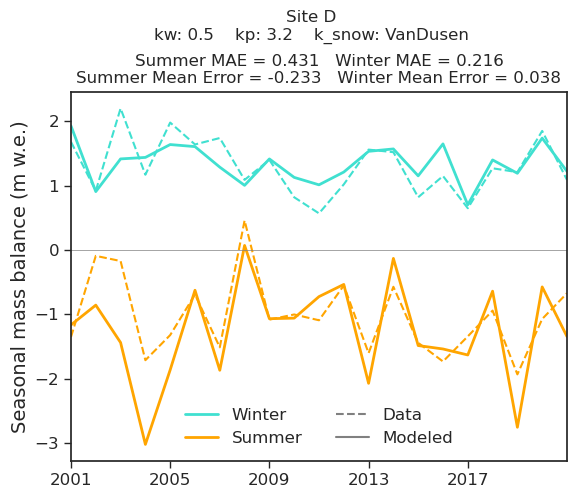

In [3]:
for site in sites:
    # ds = best[site]
    ds = dsdict[site][-1]
    # ds = xr.open_dataset(f'/home/claire/research/Output/EB/Gulkana_10_09_paramset_{site}_0.nc')
    param = 'kw' #if site == 'D' else 'a_ice'
    k_snow = ds.attrs['k_snow']
    kw = ds.attrs['kw']
    a_ice = ds.attrs['a_ice']
    kp = ds.attrs['kp']
    # kp = result_df.loc['kp',site]
    # kw = result_df.loc['kw',site]
    # a_ice = result_df.loc['a_ice',site]
    param_value = kw if param == 'kw' else a_ice # float(ds.attrs[param])
    fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
    fig.suptitle(f'Site {site}\n{param}: {param_value}    kp: {kp}    k_snow: {k_snow}',y=1.05)
    # plt.savefig(f'/home/claire/research/Output/calibration/{date}_paramsMERRA2_{site}.png',dpi=200,bbox_inches='tight')

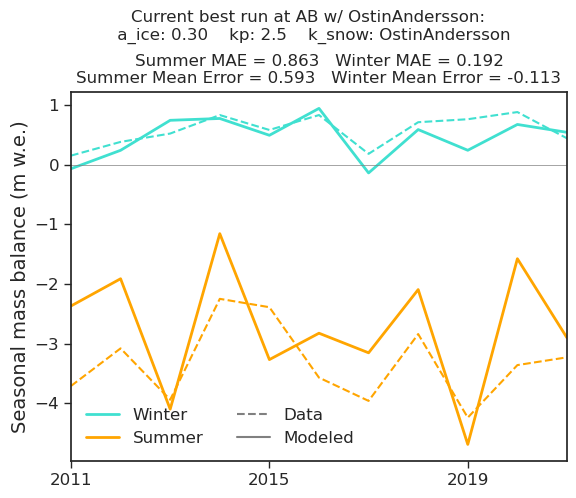

In [45]:
k_snow = ds.attrs['k_snow']
kw = ds.attrs['kw']
a_ice = ds.attrs['a_ice']
kp = ds.attrs['kp']
param_value = float(ds.attrs[param])
fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
fig.suptitle(f'Current best run at {site}: \n {param}: {param_value:.2f}    kp: {kp}    k_snow: {k_snow}',y=1.05)
# plt.show()
# plt.savefig(f'/home/claire/research/Output/calibration/10_05_0/best_{site}.png',dpi=200,bbox_inches='tight')

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])

In [235]:
best = {'winter': {key: [] for key in params_dict}, 
        'summer': {key: [] for key in params_dict}}

if summer_result.shape == (4,4,3,3):
    print('When including kw as a parameter:')
elif summer_result.shape == (4,3,3):
    print('When setting kw = 0.25 at site D, 1 elsewhere:')
for site in ['mean','AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(winter_result[idx])
    best_summer = np.argmin(summer_result[idx])
    for key in params_dict:
        best['winter'][key] = params_list[key][best_winter]
        best['summer'][key] = params_list[key][best_summer]
    if site == 'mean':
        print('Best winter parameter set overall:',best['winter'])
        print('Best summer parameter set overall:',best['summer'])
        print()
    else:
        print(f'Best winter parameter set at site {site}:',best['winter'])
        print(f'Best summer parameter set at site {site}:',best['summer'])

When setting kw = 0.25 at site D, 1 elsewhere:
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}

Best winter parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.4}
Best summer parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.2}
Best winter parameter set at site B: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site B: {'k_snow': 'Jansson', 'a_ice': 0.6}
Best winter parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.2}
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}



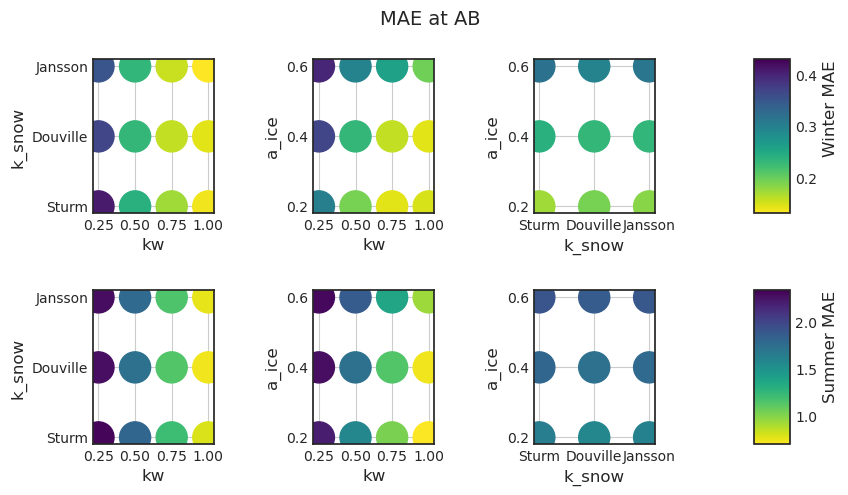

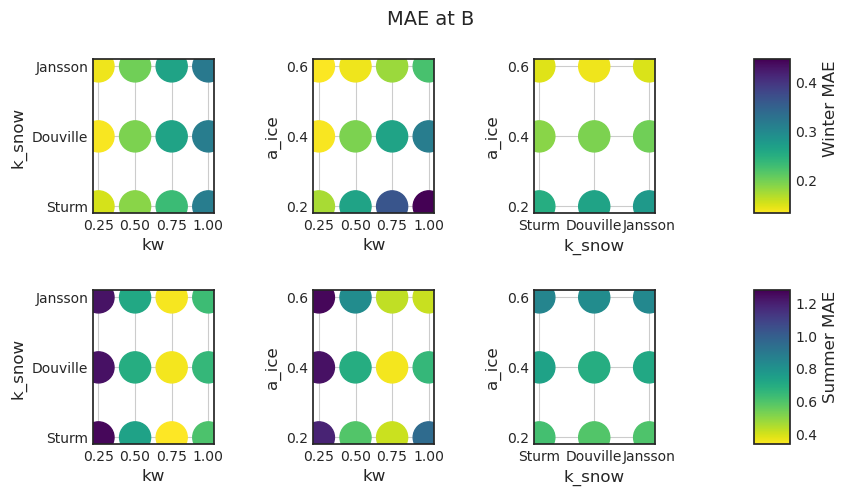

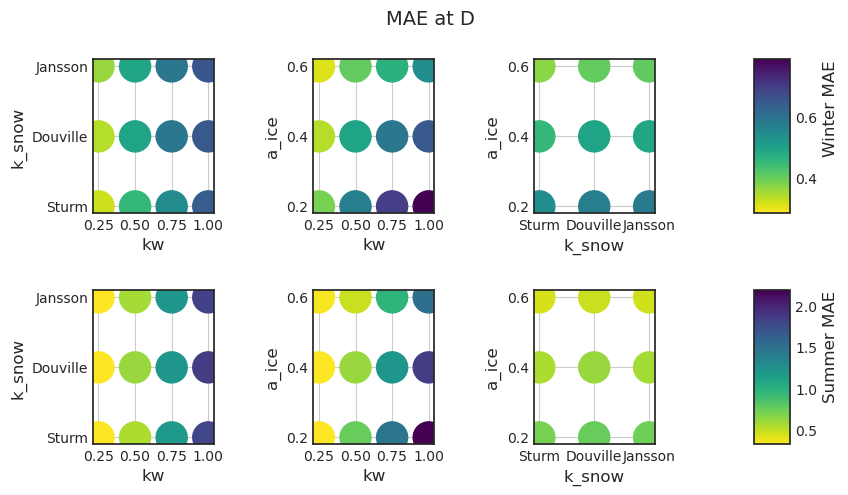

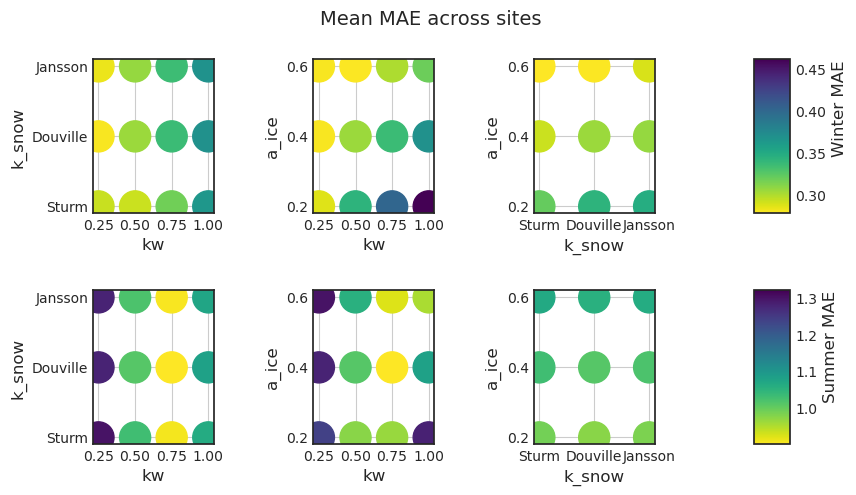

In [243]:
for site in ['AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
    fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
    if site == 'mean':
        title_first = f'Mean MAE across sites'
    else:
        title_first = f'MAE at {site}'
    if summer_result.shape == (4,4,3,3):
        fig.suptitle(title_first,fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}.png',dpi=200,bbox_inches='tight')
    elif summer_result.shape == (4,3,3):
        fig.suptitle(f'{title_first}\nWith kw=0.25 at D and 1 elsewhere',fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')